In [1]:
import torch
import os

In [2]:
# large model
dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitb14

Using cache found in /work/gz2wang/.cache/torch/hub/facebookresearch_dinov2_main
/work/gz2wang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/work/gz2wang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/work/gz2wang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [3]:
import requests
from PIL import Image
from torchvision import transforms
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )])


transform1 = transforms.Compose([
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

In [4]:
import cv2
import gc
from PIL import Image
import matplotlib.pyplot as plt 

patch_size = dinov2_vitb14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
feat_dim = 1024 # vitl14
# feat_dim = 1536 # vitg14



if torch.cuda.is_available():
  print('Using cuda!')
  device = torch.device("cuda")
  torch.cuda.empty_cache()
  dinov2_vitb14 = dinov2_vitb14.to(device)
else:
  device = torch.device("cpu")

total_features  = []


video_path = "zoom.mp4"

cap = cv2.VideoCapture(video_path)

print("Processing video...")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img = img.transpose(Image.ROTATE_270) 

    img_t = transform1(img)
    features_dict = dinov2_vitb14.forward_features(img_t.unsqueeze(0).to(device))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features.detach().cpu())


cap.release() 

print("Finished processing video!")
total_features = torch.cat(total_features, dim=0)
print(total_features.shape)

num_frames = total_features.shape[0]
print('num frames:', num_frames)

Using cuda!
Processing video...
Finished processing video!
torch.Size([331, 1369, 1024])
num frames: 331


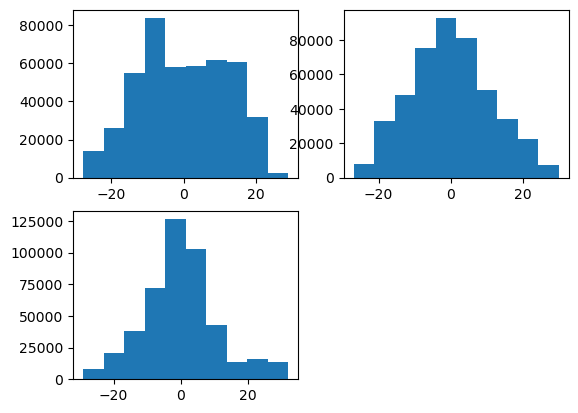

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(num_frames * patch_h * patch_w, feat_dim).cpu() #4(*H*w, 1024)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

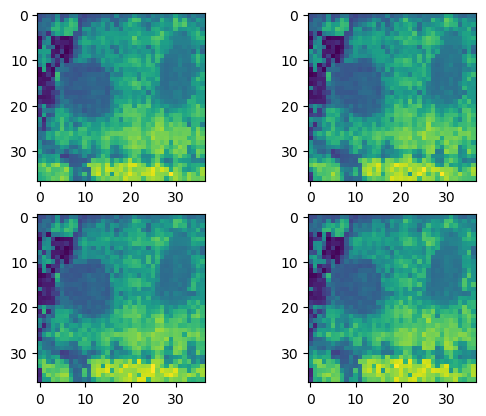

In [6]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

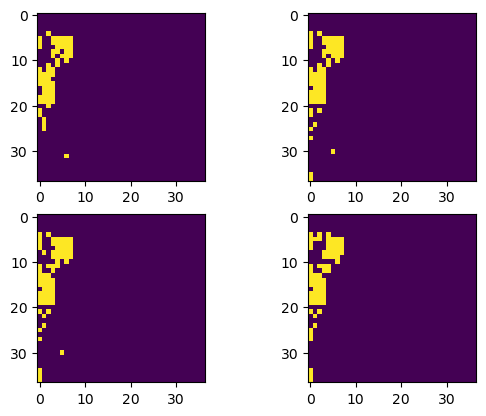

In [25]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] <= 0.2 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()


(331, 37, 37, 3)


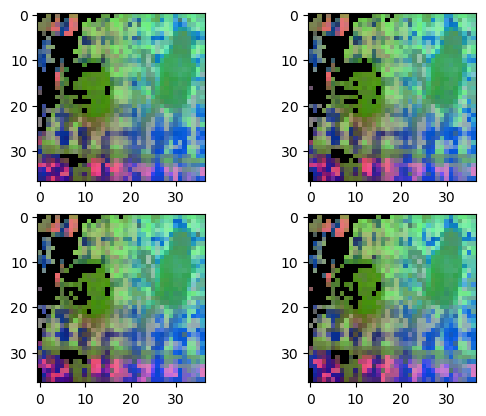

In [24]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg])
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format

pca_features_rgb = pca_features_rgb.reshape(num_frames, patch_h, patch_w, 3)
print(pca_features_rgb.shape)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

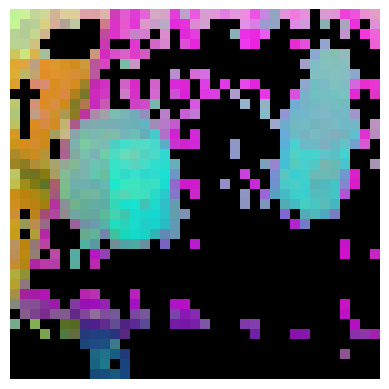

finished


In [18]:
from matplotlib import cm
import numpy as np
from base64 import b64encode
from IPython.display import HTML

#clear output dir
!rm outputPNGS/*

for i in range(num_frames):
    feature_map = pca_features_rgb[i]
    # feature_map = cm.jet((feature_map - feature_map.min()) / (feature_map.max() - feature_map.min()))[:, :, :3]
    feature_map = (feature_map * 255).astype(np.uint8)
    frame = cv2.cvtColor(feature_map, cv2.COLOR_RGB2BGR)

    if i == 0:
        plt.imshow(frame)
        plt.axis("off")  # Hide axes
        plt.show()
    pic = Image.fromarray(frame)
    pic.save('outputPNGS/output{}.png'.format(i))

cv2.destroyAllWindows()
print('finished')


